<a href="https://colab.research.google.com/github/6760525/sf_dst_ml7/blob/main/4_%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4. Практика

### Импорт библиотек

In [1]:
!pip install optuna

     |████████████████████████████████| 308 kB 4.1 MB/s 
     |████████████████████████████████| 210 kB 45.5 MB/s 
     |████████████████████████████████| 81 kB 2.8 MB/s 
     |████████████████████████████████| 78 kB 4.1 MB/s 
     |████████████████████████████████| 146 kB 39.1 MB/s 
     |████████████████████████████████| 49 kB 3.2 MB/s 
     |████████████████████████████████| 112 kB 34.3 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=99e3b10b4a998458c7ff45029917c3f3c8fdf955a8da9bebc9cf2206430c4e66
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [37]:
import numpy as np
import pandas as pd
import optuna
import warnings

from hyperopt import hp, fmin, tpe, space_eval, Trials, STATUS_OK
from sklearn import linear_model
from sklearn import metrics
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42

%matplotlib inline
plt.style.use('seaborn')

### Загрузка данных

In [3]:
data = pd.read_csv('https://lms.skillfactory.ru/assets/courseware/v1/9f2add5bca59f8c4df927432d605fff3/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/_train_sem09__1_.zip')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


Создаем матрицу наблюдений X и вектор ответов y.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3751 entries, 0 to 3750
Columns: 1777 entries, Activity to D1776
dtypes: float64(942), int64(835)
memory usage: 50.9 MB


In [5]:
X = data.drop(['Activity'], axis=1)
y = data['Activity']

Разделяем выборку на тренировочную и тестовую в соотношении 80/20.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

## **Модель A.** Логистическая регрессия

In [7]:
warnings.filterwarnings("ignore", category=UserWarning) 

log_reg = linear_model.LogisticRegression(random_state=SEED, max_iter=50)

log_reg.fit(X_train, y_train)
y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.79


### Метод GridSeachCV

In [8]:
param_grid = [{'penalty': ['l2', 'none'],
              'solver': ['lbfgs', 'sag', 'newton-cg'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]},
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]}]

grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, n_jobs = -1)

%time grid_search.fit(X_train, y_train)
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))
print("Наилучшая модель:\n{}".format(grid_search.best_estimator_))
print("Наилучшее значение точности при кросс-валидаци: {:.2f}".format(grid_search.best_score_))

CPU times: user 10.6 s, sys: 1.35 s, total: 11.9 s
Wall time: 20min 40s
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Наилучшая модель:
LogisticRegression(C=0.1, max_iter=50, random_state=42)
Наилучшее значение точности при кросс-валидаци: 0.76


*Значение метрики не изменилось, это значит, что мы не нашли комбинацию внешних параметров лучше, чем заданы по умолчанию.*

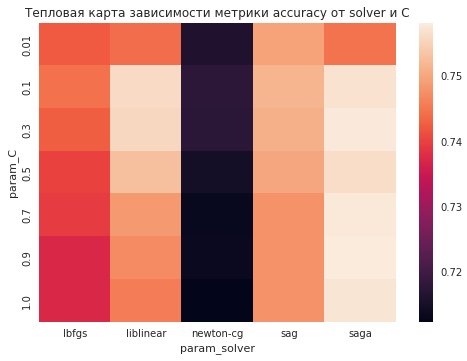

In [9]:
visual = pd.pivot_table(pd.DataFrame(grid_search.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns='param_solver')
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики accuracy от solver и С')
sns.set(rc={'figure.figsize':(12, 8)})

*Видим, что лучшие результаты показывают алгоритмы liblinear и saga, но слабая регуляризация С = 0,01 отрицательно влияет на метрику, поэтому есть смысл брать значения больше 0.01*

### Метод RandomizedSearchCV

In [64]:
params = param_grid = {'penalty': ['l2', 'l1'],
                       'solver': ['saga', 'liblinear'],
                       'C': list(np.linspace(0.05, 0.30, 10, dtype=float))},


random_search = RandomizedSearchCV(estimator=log_reg, param_distributions=params, cv=5, n_iter=10, n_jobs=-1)

%time random_search.fit(X_train, y_train)
y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

CPU times: user 5.58 s, sys: 88.1 ms, total: 5.66 s
Wall time: 1min 29s
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'solver': 'saga', 'penalty': 'l1', 'C': 0.2444444444444444}


### Метод Hyperopt

In [65]:
def hyperopt_lr(params, cv=5, X=X_train, y=y_train, random_state=SEED):
    params = {'C' : float(params['C']),
              'solver' : params['solver'],
              'penalty' : params['penalty'],
              'max_iter' : int(params['max_iter'])}

    model = linear_model.LogisticRegression(**params, random_state=random_state)

    model.fit(X, y)

    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    return {'loss': -score, 'status': STATUS_OK}

In [67]:
space = {'C' : hp.uniform('C', 0.05, 0.30),
         'solver' : hp.choice('solver', ['saga', 'liblinear']),
         'penalty': hp.choice('penalty', ['l1', 'l2']),
         'max_iter' : 50}

trials=Trials()

%time
best=fmin(hyperopt_lr,
          space=space,
          algo=tpe.suggest,
          max_evals=10,
          trials=trials,
          rstate=np.random.RandomState(SEED)
         )

bp = space_eval(space, best)
print(f"Наилучшие значения гиперпараметров {bp}")

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.54 µs
100%|██████████| 10/10 [02:20<00:00, 14.04s/it, best loss: -0.7842219360244689]
Наилучшие значения гиперпараметров {'C': 0.15950729661023083, 'max_iter': 50, 'penalty': 'l1', 'solver': 'liblinear'}


In [68]:
model = linear_model.LogisticRegression(
    random_state=SEED, 
    solver=bp['solver'],
    penalty=bp['penalty'],
    C=float(bp['C']),
    max_iter=int(bp['max_iter'])
)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.78


### Метод Optuna

In [85]:
def optuna_lr(trial):
  penalty=trial.suggest_categorical('penalty', ['l1', 'l2'])
  solver=trial.suggest_categorical('solver', ['saga', 'liblinear'])
  C=trial.suggest_float('C', 0.01, 0.30, step=0.05)

  model = linear_model.LogisticRegression(penalty=penalty,
                                          solver=solver,
                                          C=C,
                                          random_state=SEED)
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score
  

In [86]:
optuna.logging.set_verbosity(optuna.logging.ERROR)
%time
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
study.optimize(optuna_lr, n_trials=50)
print(f"Наилучшие значения гиперпараметров {study.best_params}")

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 9.3 µs
Наилучшие значения гиперпараметров {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.26}


In [87]:
model = linear_model.LogisticRegression(**study.best_params, random_state=SEED, )
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.79


## **Модель B.** Случайный лес

In [90]:
rf = ensemble.RandomForestClassifier(random_state=SEED)

rf.fit(X_train, y_train)

y_test_pred = rf.predict(X_test)

print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.81


### Метод GridSeachCV

In [91]:
param_grid = {'n_estimators': list(range(50, 200, 50)),
              'min_samples_leaf': [5, 7, 9],
              'max_depth': list(np.linspace(10, 40, 10, dtype=int))
              }

rf_grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs = -1)

%time rf_grid_search.fit(X_train, y_train)
y_test_pred = rf_grid_search.predict(X_test)

print("Наилучшие значения гиперпараметров: {}".format(rf_grid_search.best_params_))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))


CPU times: user 6.74 s, sys: 436 ms, total: 7.17 s
Wall time: 6min 42s
Наилучшие значения гиперпараметров: {'max_depth': 16, 'min_samples_leaf': 7, 'n_estimators': 100}
f1_score на тестовом наборе: 0.81


### Метод RandomizedSearchCV

In [92]:
params = {'n_estimators': list(range(50, 200, 50)),
          'min_samples_leaf': list(np.linspace(1, 10, 1, dtype=int)),
          'max_depth': list(np.linspace(10, 40, 10, dtype=int))
}

random_search = RandomizedSearchCV(estimator=rf, param_distributions=params, cv=5, n_iter=10, n_jobs=-1)

%time random_search.fit(X_train, y_train)
y_test_pred = random_search.predict(X_test)
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))


CPU times: user 2.5 s, sys: 69.9 ms, total: 2.57 s
Wall time: 49.8 s
Наилучшие значения гиперпараметров: {'n_estimators': 100, 'min_samples_leaf': 1, 'max_depth': 23}
f1_score на тестовом наборе: 0.82


### Метод Hyperopt

In [93]:
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=SEED):
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
              'min_samples_leaf': int(params['min_samples_leaf'])}
  
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    model.fit(X, y)
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
  
    return {'loss': -score, 'status': STATUS_OK}

In [95]:
space={'n_estimators': hp.quniform('n_estimators', 50, 200, 1),
       'max_depth' : hp.quniform('max_depth', 1, 40, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

%time
best=fmin(hyperopt_rf,
          space=space,
          algo=tpe.suggest,
          max_evals=50,
          trials=Trials(),
          rstate=np.random.RandomState(SEED)
         )

bp = space_eval(space, best)
print(f"Наилучшие значения гиперпараметров {bp}")

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 10.7 µs
100%|██████████| 50/50 [07:09<00:00,  8.59s/it, best loss: -0.8098984122336983]
Наилучшие значения гиперпараметров {'max_depth': 22.0, 'min_samples_leaf': 2.0, 'n_estimators': 140.0}


In [96]:
model = ensemble.RandomForestClassifier(
    random_state=SEED,
    n_estimators=int(bp['n_estimators']),
    max_depth=int(bp['max_depth']),
    min_samples_leaf=int(bp['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.82


### Метод Optuna

In [102]:
def optuna_rf(trial):
  n_estimators = trial.suggest_int('n_estimators', 50, 200, 1)
  max_depth = trial.suggest_int('max_depth', 1, 40, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=SEED)

  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score
  

In [103]:
optuna.logging.set_verbosity(optuna.logging.ERROR)
%time
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
study.optimize(optuna_rf, n_trials=50)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs


In [104]:
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
model = ensemble.RandomForestClassifier(**study.best_params, random_state=SEED, )
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Наилучшие значения гиперпараметров {'n_estimators': 117, 'max_depth': 28, 'min_samples_leaf': 2}
f1_score на тестовом наборе: 0.82
